<a href="https://colab.research.google.com/github/Alvis12/deep_learning/blob/main/Rainfall(Timeseries_Forecast)_ANN_Demo_for_class_2023_Student_ver(Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Note: Some metrics need to be defined manually

In [5]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [6]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/pythonData/python_demo_data/Rainfall_Forecast.csv')
# Colab
df = pd.read_csv('/content/drive/MyDrive/ann_timeseries/GOLD.csv')
df

,Date,Close
0,2020/5/22,26.320000
1,2020/5/26,24.730000
2,2020/5/27,23.920000
3,2020/5/28,23.950001
4,2020/5/29,24.000000
...,...,...
749,2023/5/15,19.350000
750,2023/5/16,18.760000
751,2023/5/17,18.430000
752,2023/5/18,17.809999


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [ ]:
# 1.1 Convert date
df['Date']=pd.to_datetime(df.iloc[:,[0,1,2]])
df

,Year,Month,Day,Y,Date
0,2000,1,1,48.25,2000-01-01
1,2000,2,1,50.81,2000-02-01
2,2000,3,1,42.88,2000-03-01
3,2000,4,1,55.69,2000-04-01
4,2000,5,1,70.88,2000-05-01
...,...,...,...,...,...
247,2020,8,1,92.31,2020-08-01
248,2020,9,1,90.12,2020-09-01
249,2020,10,1,82.69,2020-10-01
250,2020,11,1,76.06,2020-11-01


In [7]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    754 non-null    object 
 1   Close   754 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.9+ KB


In [ ]:
new_df=df.iloc[:,[4,3]].copy()
new_df.head()

,Date,Y
0,2000-01-01,48.25
1,2000-02-01,50.81
2,2000-03-01,42.88
3,2000-04-01,55.69
4,2000-05-01,70.88


In [8]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
df.describe() #統計呈現

,Close
count,754.000000
mean,20.966830
std,3.890192
min,13.100000
25%,18.389999
50%,20.284999
75%,23.607501
max,30.459999


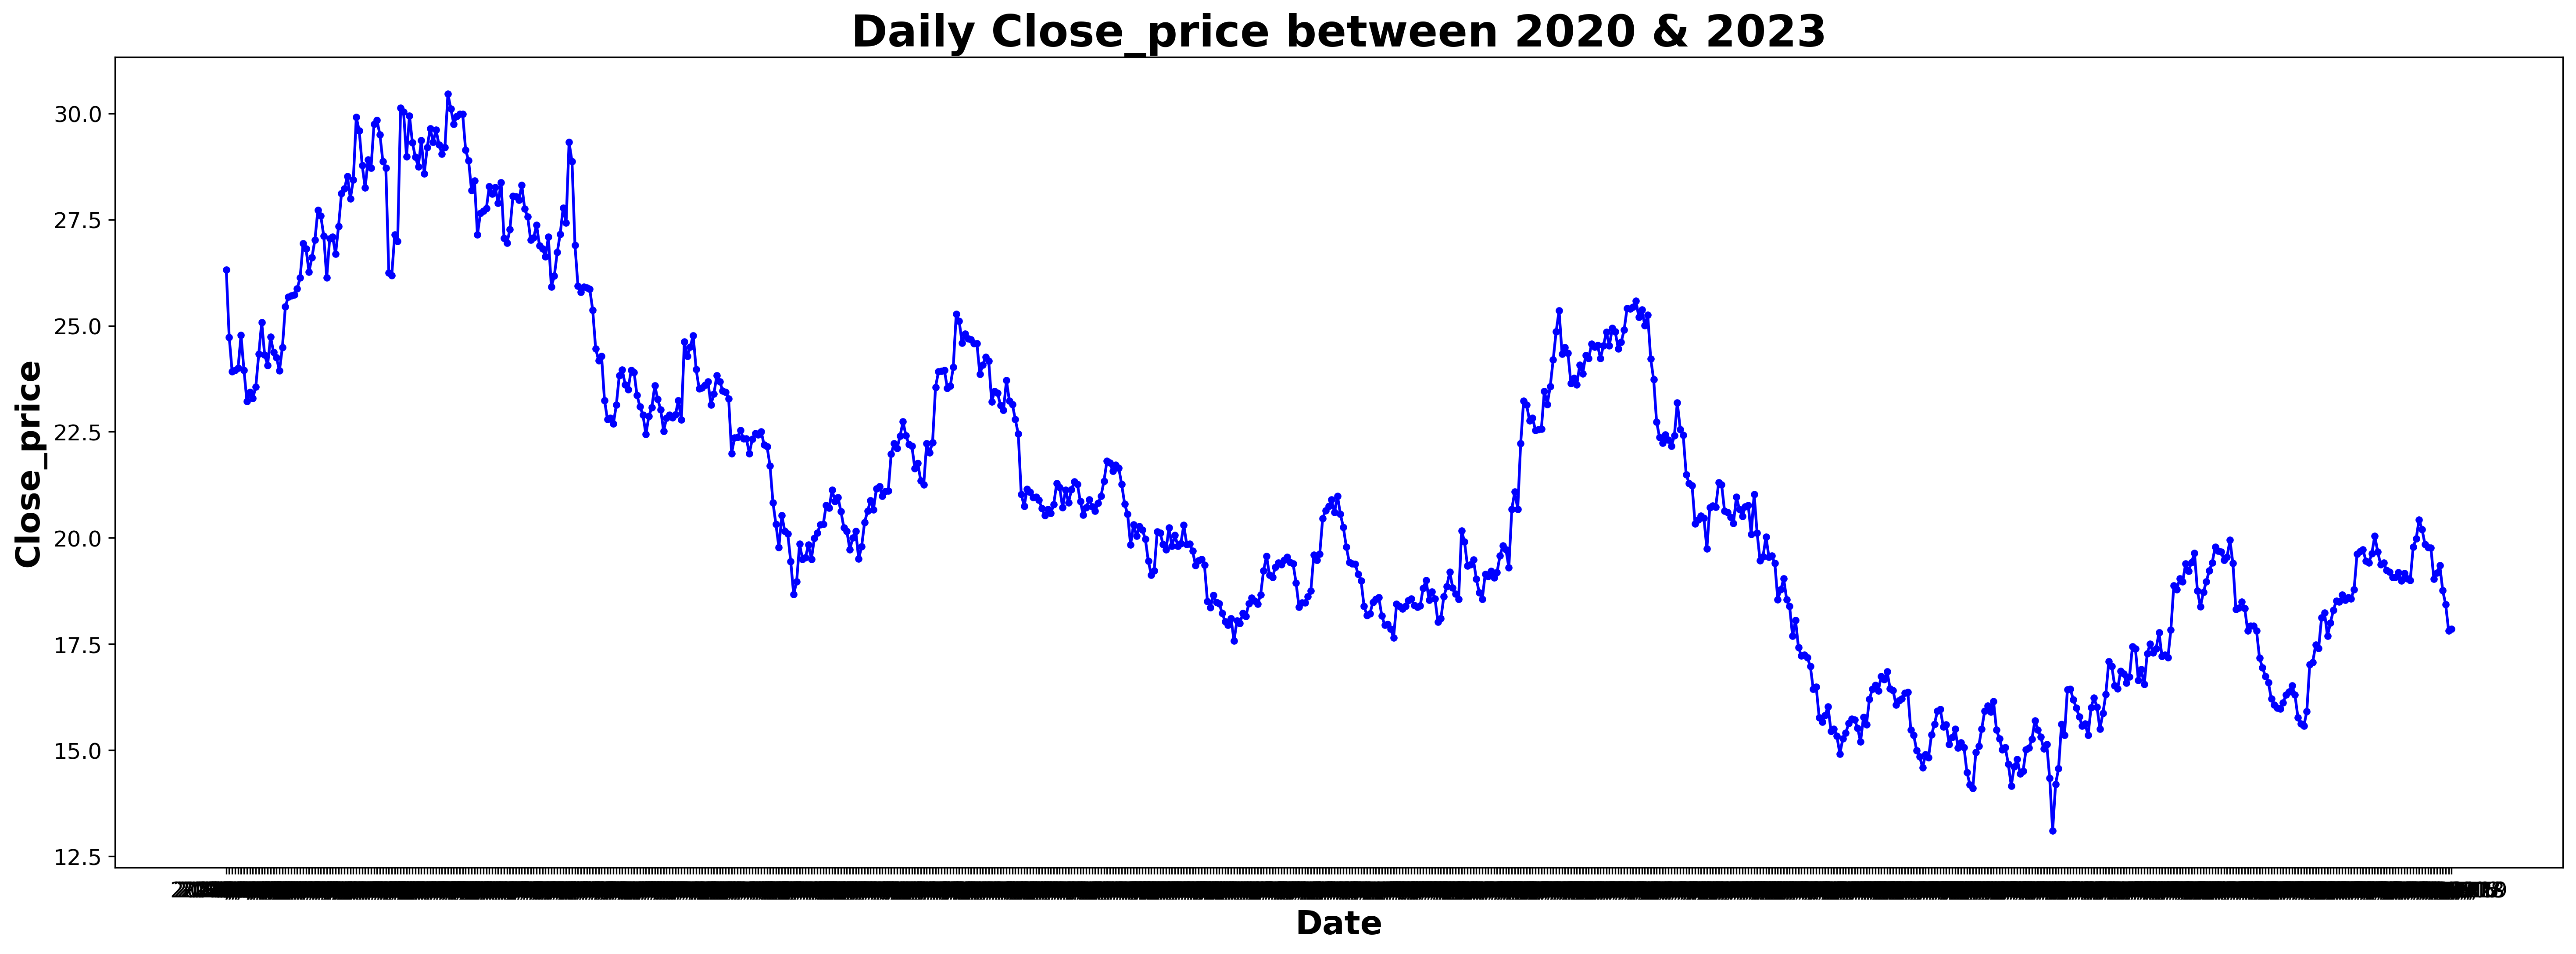

In [9]:
# Plot Y and its corresponding date
# Figure setting

#把圖表畫出來 底下黑黑的是因為日期太多不夠位置寫
plt.figure(figsize=(24,8),dpi=300)
plt.title('Daily Close_price between 2020 & 2023',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close_price',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(df['Date'],df['Close'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [10]:
# Create 3 lags
#做3個time_lag出來 有NaN是因為時間序列裡未發生的事情不能做為資料來分析
df['Lag_1']=df['Close'].shift(1).copy()
df['Lag_2']=df['Close'].shift(2).copy()
df['Lag_3']=df['Close'].shift(3).copy()
df.head()

,Date,Close,Lag_1,Lag_2,Lag_3
0,2020/5/22,26.320000,NaN,NaN,NaN
1,2020/5/26,24.730000,26.320000,NaN,NaN
2,2020/5/27,23.920000,24.730000,26.32,NaN
3,2020/5/28,23.950001,23.920000,24.73,26.32
4,2020/5/29,24.000000,23.950001,23.92,24.73


In [11]:
# Drop out missing values and rest index

#解決辦法為把資料整筆刪掉
clean_df=df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1,Lag_2,Lag_3
0,2020/5/28,23.950001,23.920000,24.730000,26.320000
1,2020/5/29,24.000000,23.950001,23.920000,24.730000
2,2020/6/1,24.780001,24.000000,23.950001,23.920000
3,2020/6/2,23.950001,24.780001,24.000000,23.950001
4,2020/6/3,23.219999,23.950001,24.780001,24.000000
...,...,...,...,...,...
746,2023/5/15,19.350000,19.180000,19.030001,19.770000
747,2023/5/16,18.760000,19.350000,19.180000,19.030001
748,2023/5/17,18.430000,18.760000,19.350000,19.180000
749,2023/5/18,17.809999,18.430000,18.760000,19.350000


In [ ]:
# Export the data
#clean_df.to_csv('D:/data_analysis/PyExport/Rainfall_Lags.csv',index=False, header=True)
# Colab
#clean_df.to_csv('Rainfall_Lags.csv',index=False, header=True)

# 3. Data preprocessing under time-series structure

A total of 21 years are in the data set. In this practice, we will use the last three years of data as the testing set

In [12]:
# Train data
Forecast_train_data=clean_df.iloc[0:751,:].copy() #754-3=751 總共751比扣掉前面刪掉的3筆有NaN的資料
Forecast_train_data

,Date,Close,Lag_1,Lag_2,Lag_3
0,2020/5/28,23.950001,23.920000,24.730000,26.320000
1,2020/5/29,24.000000,23.950001,23.920000,24.730000
2,2020/6/1,24.780001,24.000000,23.950001,23.920000
3,2020/6/2,23.950001,24.780001,24.000000,23.950001
4,2020/6/3,23.219999,23.950001,24.780001,24.000000
...,...,...,...,...,...
746,2023/5/15,19.350000,19.180000,19.030001,19.770000
747,2023/5/16,18.760000,19.350000,19.180000,19.030001
748,2023/5/17,18.430000,18.760000,19.350000,19.180000
749,2023/5/18,17.809999,18.430000,18.760000,19.350000


In [13]:
# Test data
Forecast_test_data=clean_df.iloc[657:657+94,:].copy() #657為training的部分
Forecast_test_data

,Date,Close,Lag_1,Lag_2,Lag_3
657,2023/1/5,18.780001,18.879999,17.830000,17.180000
658,2023/1/6,19.040001,18.780001,18.879999,17.830000
659,2023/1/9,18.969999,19.040001,18.780001,18.879999
660,2023/1/10,19.389999,18.969999,19.040001,18.780001
661,2023/1/11,19.219999,19.389999,18.969999,19.040001
...,...,...,...,...,...
746,2023/5/15,19.350000,19.180000,19.030001,19.770000
747,2023/5/16,18.760000,19.350000,19.180000,19.030001
748,2023/5/17,18.430000,18.760000,19.350000,19.180000
749,2023/5/18,17.809999,18.430000,18.760000,19.350000


# 4. Prepare time-series data for train/validation structure manually

 Here we have a total of 3 (751) years of data in training data set that are ready to be further splitted into training and validation data set

3 (751) years of data can be evenlly divided into 7 portions (94 in each portion)

# Expanding window

In [ ]:
#我用rolling
"""
# Expanding 1
Exp_training_1=Forecast_train_data.iloc[0:105,:].copy()
Exp_val_1=Forecast_train_data.iloc[105:105+36,:].copy()

# Expanding 2
Exp_training_2=Forecast_train_data.iloc[0:141,:].copy()
Exp_val_2=Forecast_train_data.iloc[141:141+36,:].copy()

# Expanding 3
Exp_training_3=Forecast_train_data.iloc[0:177,:].copy()
Exp_val_3=Forecast_train_data.iloc[177:177+36,:].copy()
"""

# Rolling window

In [14]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:375,:].copy() #375=93+94*3
Rol_val_1=Forecast_train_data.iloc[375:375+94,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[93:469,:].copy() #469=93+94*4
Rol_val_2=Forecast_train_data.iloc[469:469+94,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[187:563,:].copy() #563=93+94*5
Rol_val_3=Forecast_train_data.iloc[563:563+94,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X) 

In [ ]:
#set x (make prediction)
#我用rolling
"""
# Train
x_train=Exp_training_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Exp_val_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Exp_training_3['Close'].copy()
y_val=Exp_val_3['Close'].copy()
"""

NameError: ignored

In [15]:
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_1['Close'].copy()
y_val=Rol_val_1['Close'].copy()

# 6. Creating Net 

In [16]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.492236,0.555124,0.678571
1,0.494565,0.492236,0.555124
2,0.498447,0.494565,0.492236
3,0.559006,0.498447,0.494565
4,0.494565,0.559006,0.498447


In [17]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [18]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.   

# Sequential style coding for creating net

In [135]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='linear'))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='relu'))

# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.007,beta_1=0.97)  #learning_rate3種 加上 beta3種 的組合
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 445
Trainable params: 445
Non-trainable params: 0
_________________________________________________________________


Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model (train/validation)

In [136]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
6/6 [==============================] - 1s 37ms/step - loss: 23.2127 - mean_absolute_percentage_error: 99.6867 - val_loss: 20.3362 - val_mean_absolute_percentage_error: 98.1292
Epoch 2/300
6/6 [==============================] - 0s 8ms/step - loss: 22.5421 - mean_absolute_percentage_error: 96.8990 - val_loss: 19.5288 - val_mean_absolute_percentage_error: 94.3759
Epoch 3/300
6/6 [==============================] - 0s 8ms/step - loss: 21.4559 - mean_absolute_percentage_error: 92.3563 - val_loss: 18.1767 - val_mean_absolute_percentage_error: 88.0889
Epoch 4/300
6/6 [==============================] - 0s 10ms/step - loss: 19.6331 - mean_absolute_percentage_error: 84.7305 - val_loss: 15.9095 - val_mean_absolute_percentage_error: 77.5638
Epoch 5/300
6/6 [==============================] - 0s 13ms/step - loss: 16.6212 - mean_absolute_percentage_error: 72.1943 - val_loss: 12.3010 - val_mean_absolute_percentage_error: 60.8023
Epoch 6/300
6/6 [==============================] - 0s 8ms/step

In [137]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

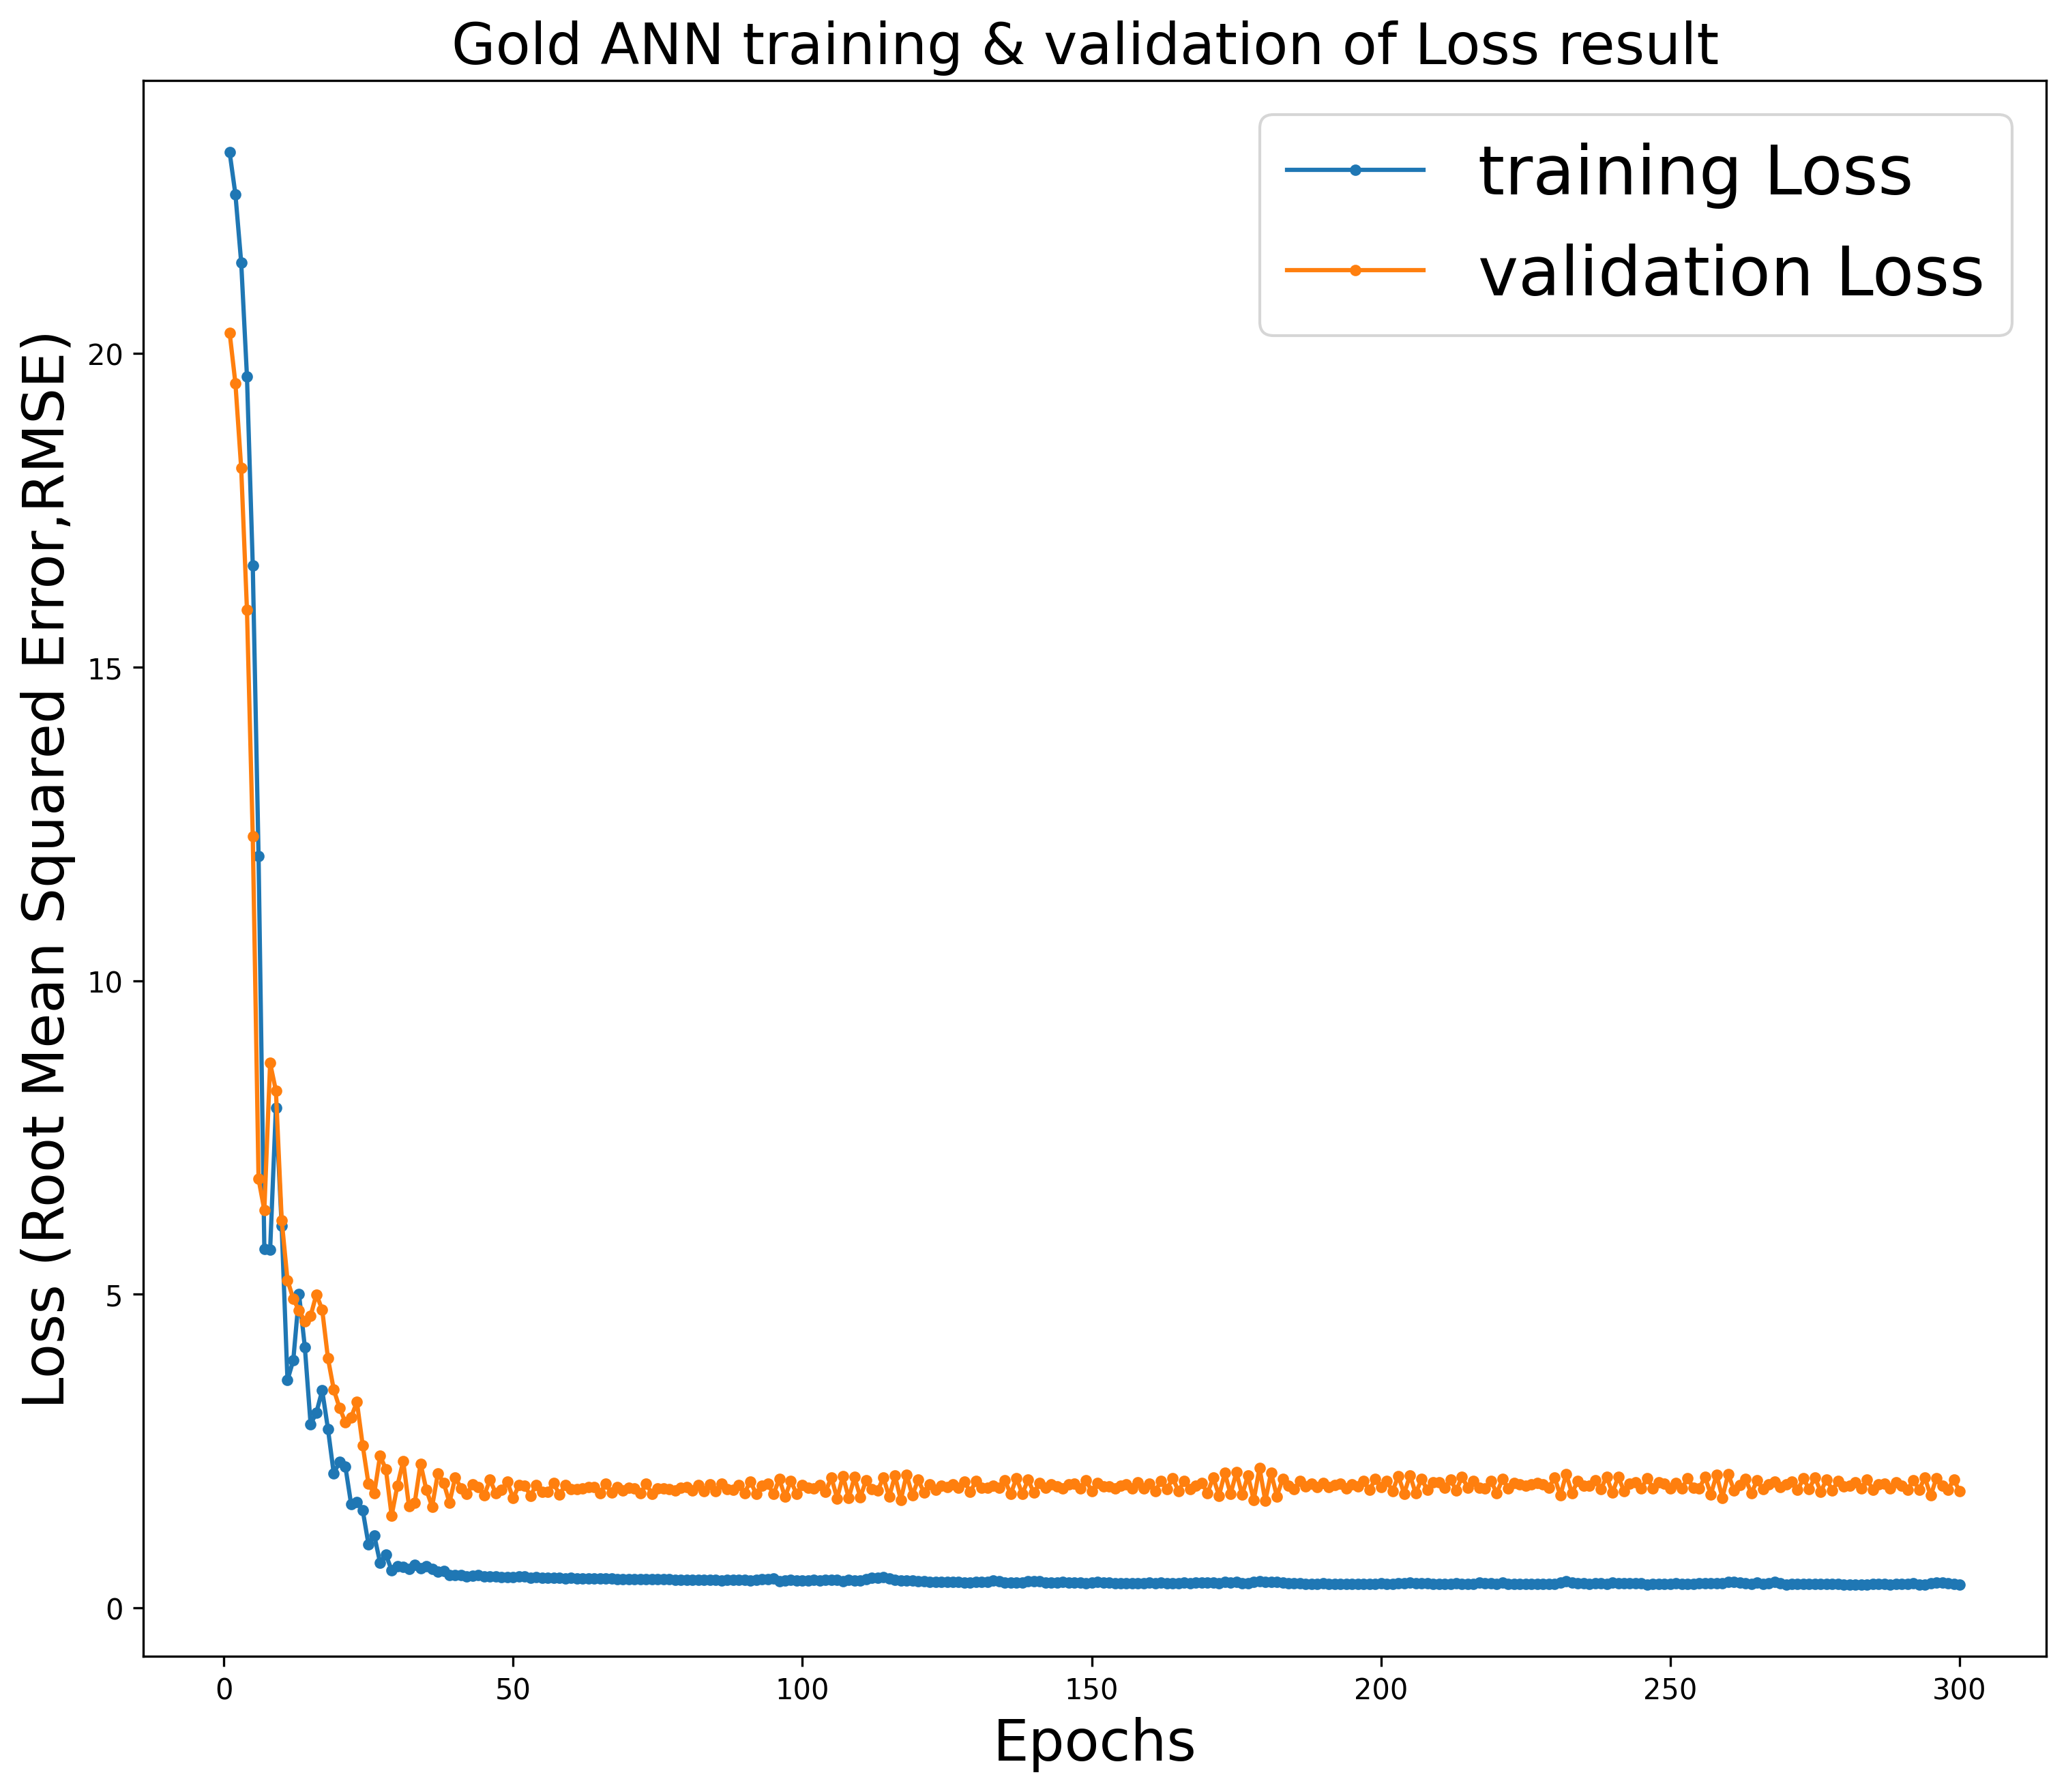

In [138]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Gold ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

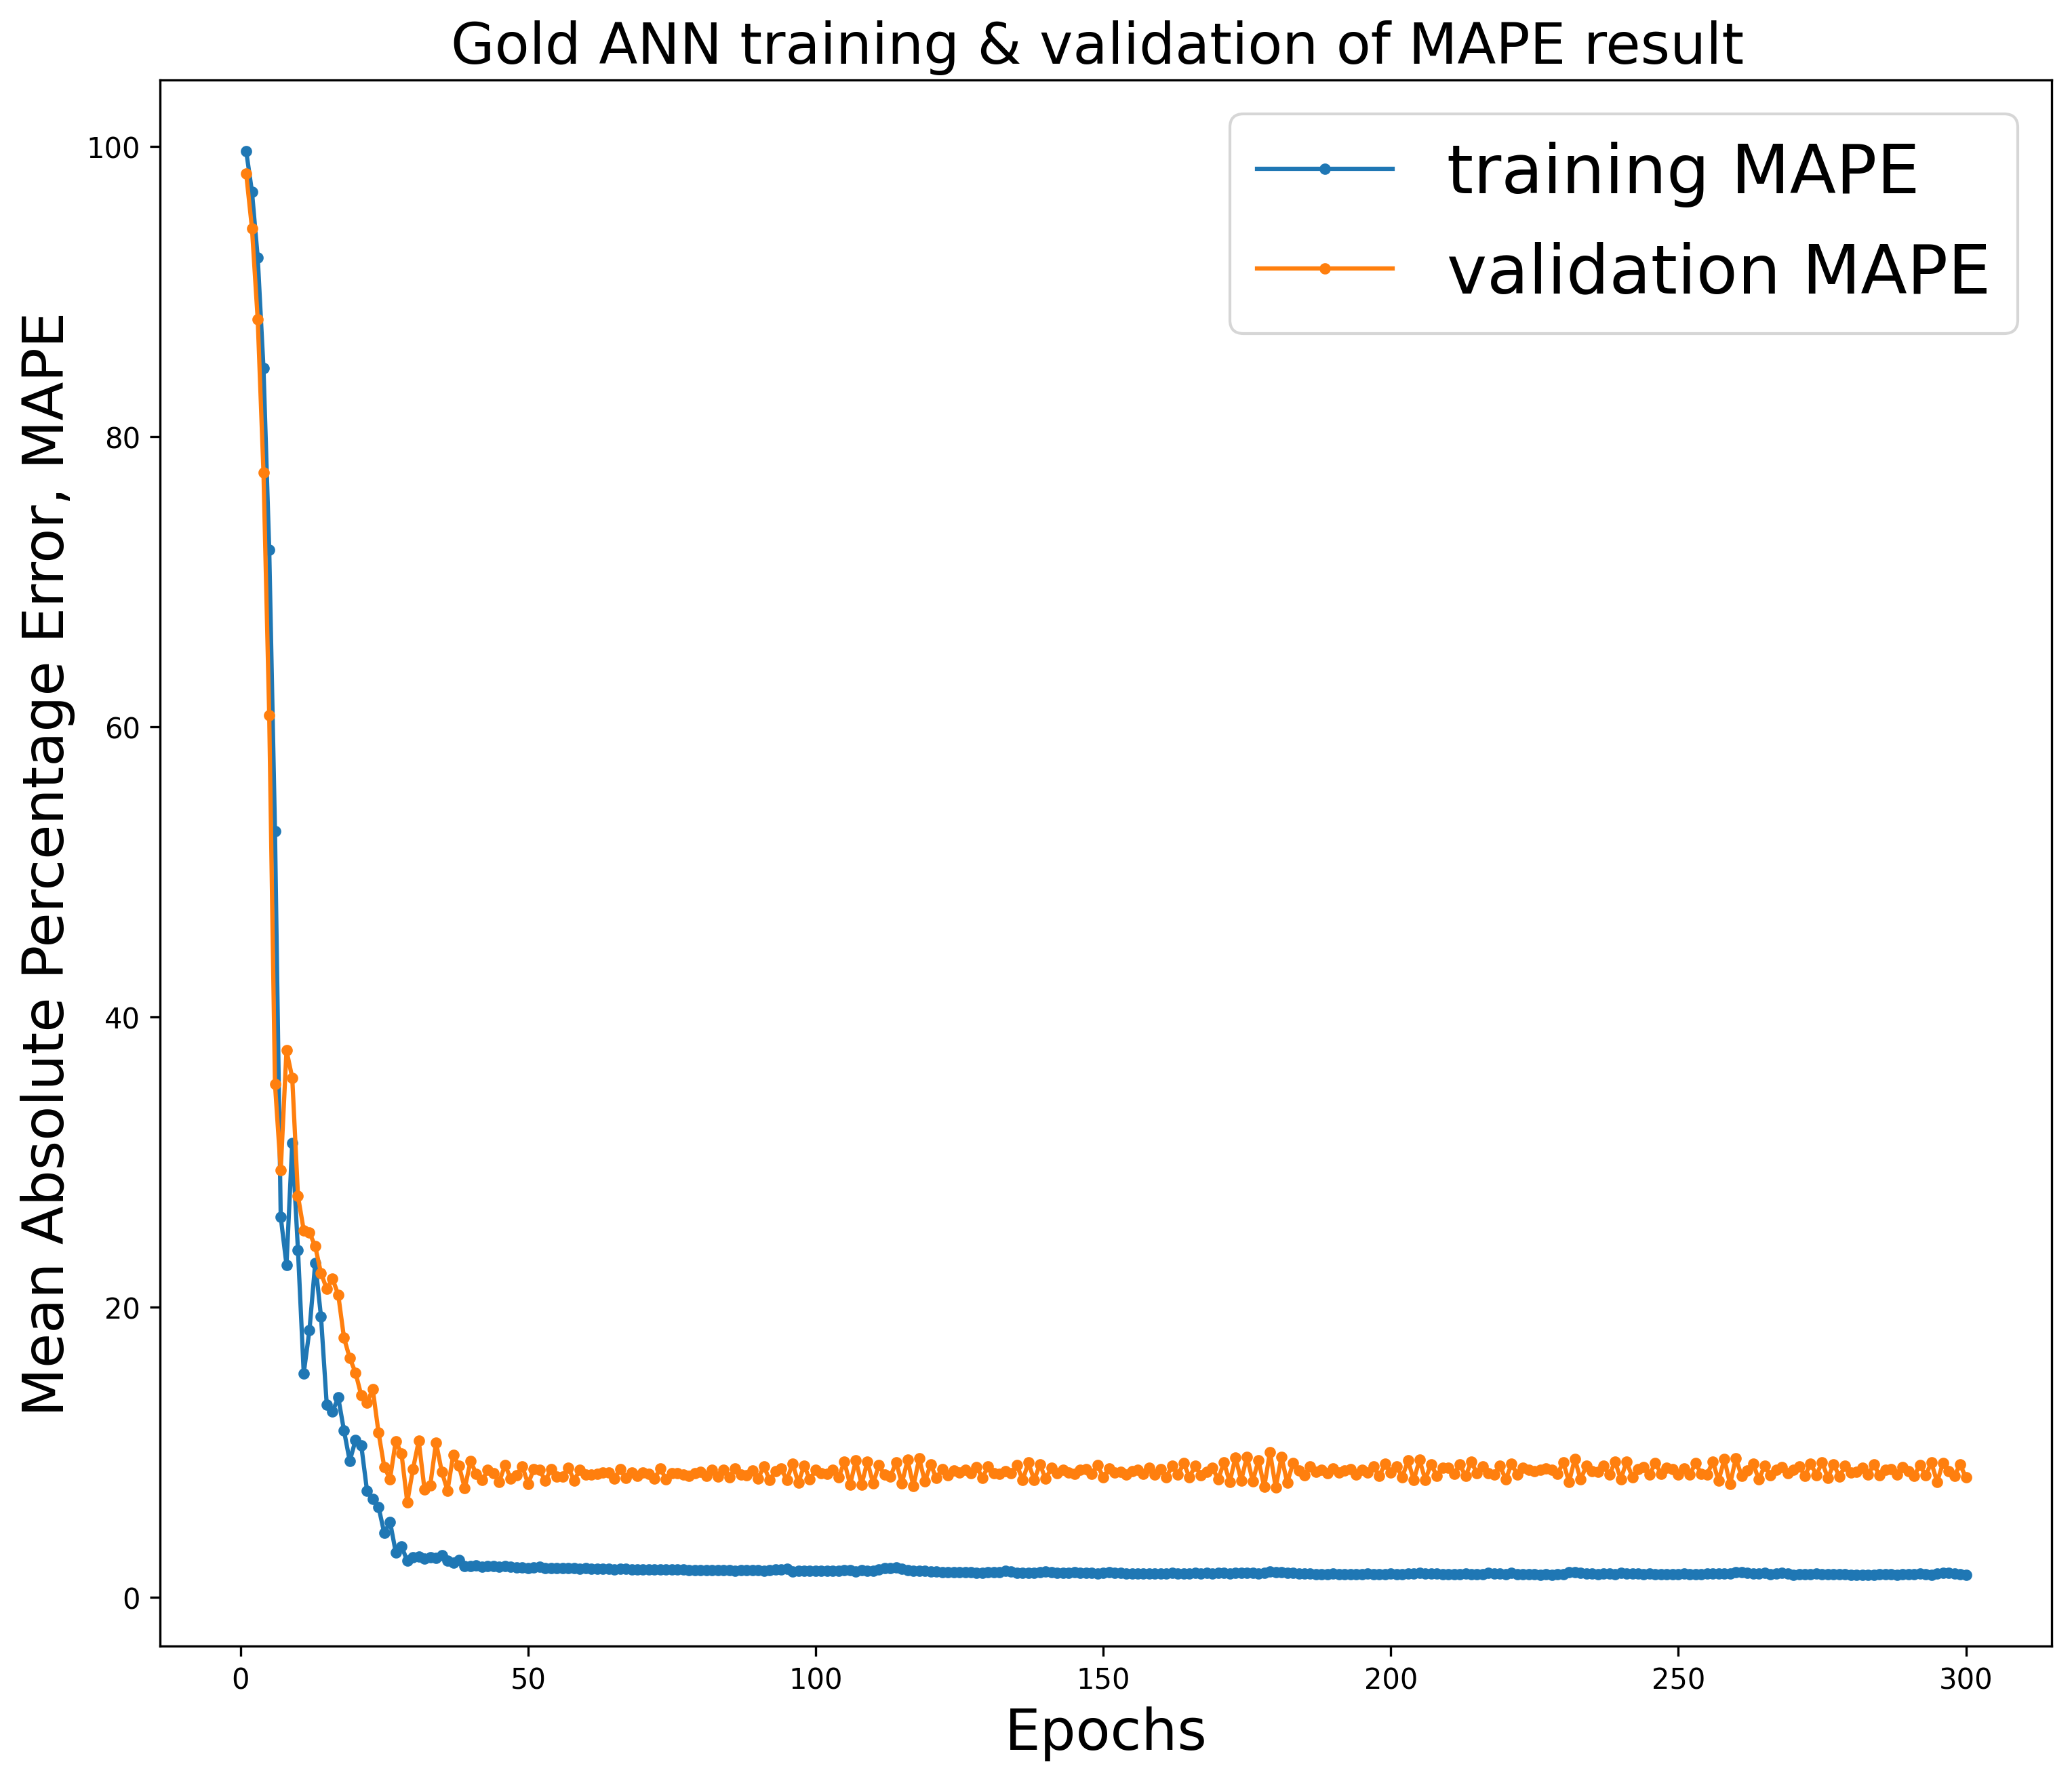

In [139]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Gold ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [140]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Close'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Close'].copy()

In [143]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# Add second hidden layer
Fmodel.add(Dense(units=12, activation='linear'))

# Add third hidden layer
Fmodel.add(Dense(units=24, activation='relu'))

# Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.007,beta_1=0.97)  #learning_rate0.002 加上 beta0.95 的組合
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 445
Trainable params: 445
Non-trainable params: 0
_________________________________________________________________


In [144]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=64,verbose=1)

Epoch 1/300
12/12 [==============================] - 0s 3ms/step - loss: 6.1188 - mean_absolute_percentage_error: 29.2566
Epoch 2/300
12/12 [==============================] - 0s 3ms/step - loss: 1.8870 - mean_absolute_percentage_error: 8.9635
Epoch 3/300
12/12 [==============================] - 0s 4ms/step - loss: 1.5323 - mean_absolute_percentage_error: 7.2889
Epoch 4/300
12/12 [==============================] - 0s 3ms/step - loss: 1.1952 - mean_absolute_percentage_error: 5.7091
Epoch 5/300
12/12 [==============================] - 0s 3ms/step - loss: 0.7961 - mean_absolute_percentage_error: 3.7774
Epoch 6/300
12/12 [==============================] - 0s 3ms/step - loss: 0.8126 - mean_absolute_percentage_error: 3.9037
Epoch 7/300
12/12 [==============================] - 0s 3ms/step - loss: 0.6752 - mean_absolute_percentage_error: 3.2663
Epoch 8/300
12/12 [==============================] - 0s 3ms/step - loss: 0.6154 - mean_absolute_percentage_error: 2.9296
Epoch 9/300
12/12 [============

In [145]:
# 7.3 Save the trained model
#Fmodel.save('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
Fmodel.save('/content/drive/MyDrive/ann_timeseries/Gold_ANN_trained_model_9.h5')
print('Model has been saved...')

Model has been saved...


In [146]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('/content/drive/MyDrive/ann_timeseries/Gold_ANN_trained_model_9.h5')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [147]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Close'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Close'].copy()

In [148]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [149]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Close_true':Forecast_test_data['Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Close_true']-Results['Predict'])
Results

,Date,Close_true,Predict,abs Error
657,2023/1/5,18.780001,18.799999,0.019998
658,2023/1/6,19.040001,18.639999,0.400002
659,2023/1/9,18.969999,19.110001,0.140002
660,2023/1/10,19.389999,18.980000,0.409999
661,2023/1/11,19.219999,19.450001,0.230002
...,...,...,...,...
746,2023/5/15,19.350000,19.370001,0.020001
747,2023/5/16,18.760000,19.370001,0.610001
748,2023/5/17,18.430000,18.790001,0.360001
749,2023/5/18,17.809999,18.600000,0.790001


In [150]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 0.272
MSE: 0.13
RMSE: 0.36
MAPE: 1.487 %
SMAPE: 1.482 %
RAE: 0.265
MRAE: 0.002821834635653282
MdRAE: 0.242 bench: 18.451
RSE: 0.082
RRSE: 0.287


#  Plot for comparing true value & predicted value 

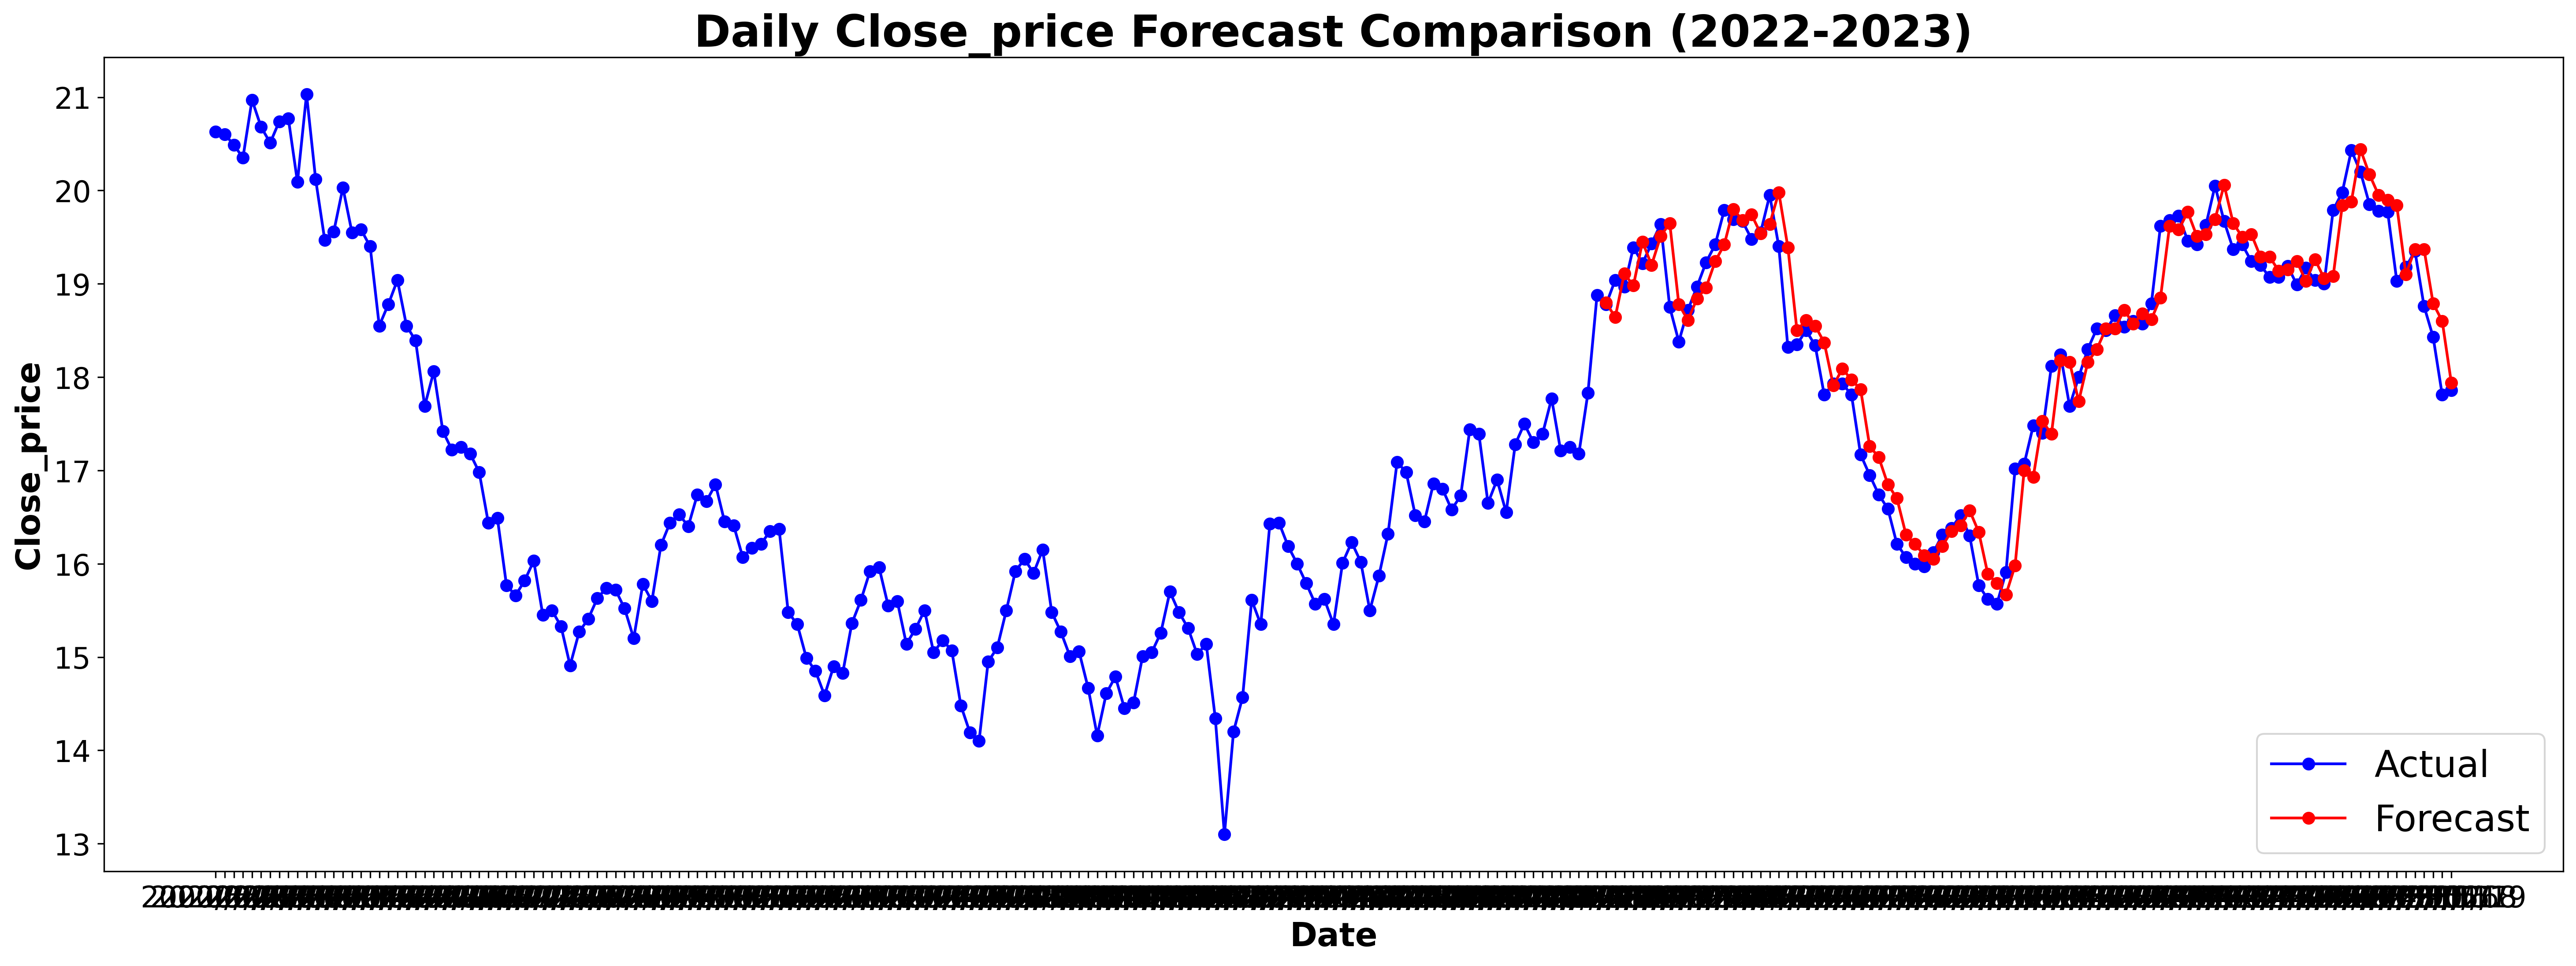

In [151]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Daily Close_price Forecast Comparison (2022-2023)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close_price',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[504:,0],clean_df.iloc[504:,1],marker='o',color='blue',label='Actual')  #504是從2022-5-19  到2023-5-19(結束)
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

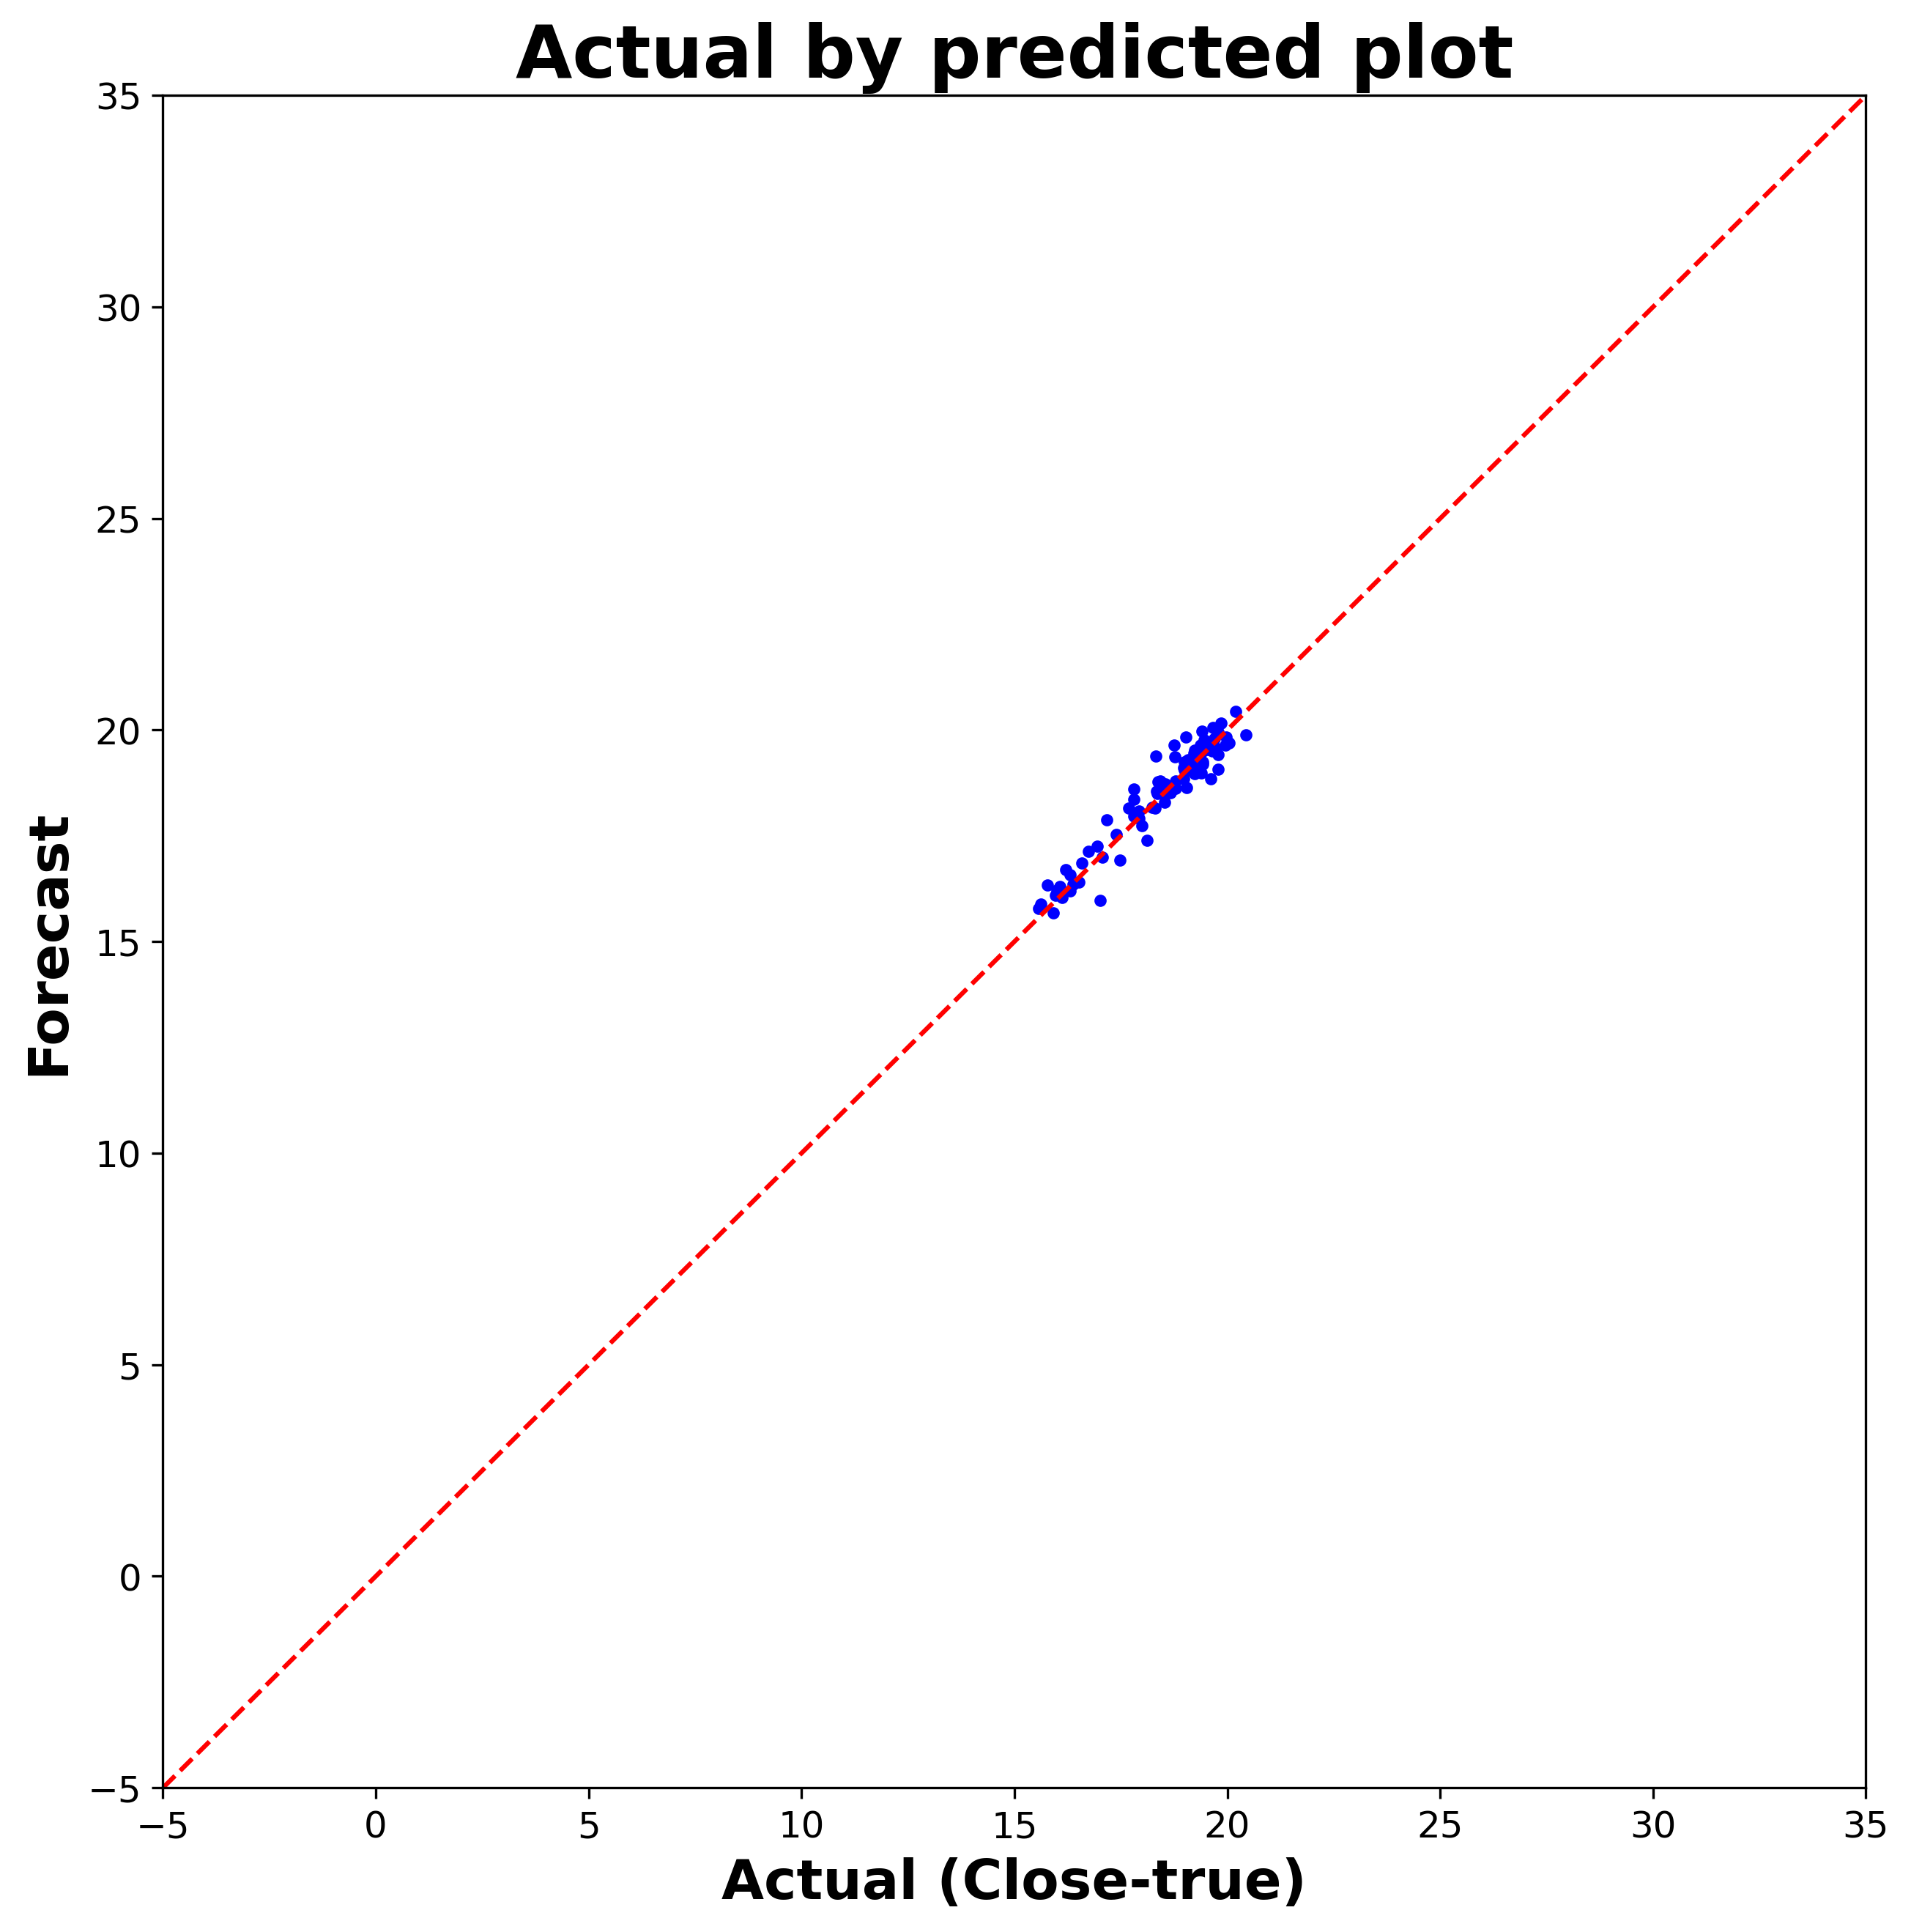

In [152]:
# Lock the scale of axis by Y_true
max_value=30+5  #比例尺改成這樣比較清楚
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Close-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()